In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math

import sys
sys.path.append('../scripts/code')

from pce import PCE
import distribution as distr
from test_functions_a import *

%matplotlib inline

In [2]:
seed = 0
np.random.seed(seed)

In [3]:
n_test = 10**6 #10**7 #!!!

In [4]:
sample_sizes = None

In [5]:
num_runs = 100 #30 #!!!

In [40]:
exp_name = 'experiments/test_risk_diff_basis_ls_2_'
save_all = True 

# Ishigami 

In [7]:
#  =======================================================================
# Define Ishigami 

dim = 3
def function(X):
    return ishigami(X)[:, np.newaxis]


lb = -1.0 * math.pi
ub = math.pi 

true_Sobol_indices = get_indices_ishigami(full=True) # 


#  ==================================================================
# Approximation setting

max_degrees = [4, 5, 6] #!!!


#  ==================================================================
# Experiment setting

start_power = 2 #2
end_power = 6 #!!#3.5 # training sample size = 10^end_power
num = 110 #6 #50 # 110

#  ==================================================================


function_name = 'Ishigami'
function_parameters = {}

In [41]:
exp_name += function_name

In [51]:
import os
import dill
print(dill.__version__)

db_name = exp_name+'.db'
if os.path.isfile(db_name):
    print('\n=============== Loading %s ======================\n'%db_name)
    dill.load_session(db_name) #!!!
    raise SystemExit("Workspace is loaded.")
else:
    print('Workspace %s not found'%db_name)

0.3.1.1
Workspace experiments/test_risk_diff_basis_ls_2_Ishigami.db not found


### Code

In [8]:
ranges = lb * np.ones((dim, 2))
ranges[:, 0] = ub


test_X = np.random.rand(n_test, dim)
test_X = (ranges[:, 1] - ranges[:, 0]) * test_X + ranges[:, 0]


test_Y = function(test_X)

true_SI_full = true_Sobol_indices['main']
true_TI_full = true_Sobol_indices['total']

groups = tuple(true_SI_full.keys())

S_full = [true_SI_full[g] for g in groups]
T_full = [true_TI_full[g] for g in groups]


In [9]:
indices_full_number = len(groups)
indices_full_number

7

In [10]:
L = np.max(np.abs(test_Y))

var_f = np.var(test_Y)

var_f, L

(13.856448886868698, 17.713165739816645)

In [12]:
def get_model_limit_mse(model, test_X, test_Y):
    
    test_size = int(len(test_X)*0.3)
    print('train size:', len(test_X)-test_size, ' + test size:', test_size)
    
    lambdas = np.array([0, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])
    
    err = []
    for ls_lambda in lambdas:
        model.fit(test_X[test_size:], test_Y[test_size:], method='ls', ls_lambda=ls_lambda)
        err += [ model.validate(test_X[:test_size], test_Y[:test_size])['mse'] ]
        
    err = np.array(err)
    print('Errors:', err)
    print('lambda opt:', lambdas[err == np.min(err)])
    
    return np.min(err)



In [13]:
%%time


#N = model._basis_functions_number

if sample_sizes is None:
    sample_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)
print('sample_sizes', sample_sizes)
max_n = max(sample_sizes)


err_S_list_Legendre = []
err_S_list_Trigonometric = []
N_list = []

mse_list_Legendre = [] 
mse_list_Trigonometric = []



method = 'ls' #'projection' # #!!!
print('\nMethod:', method, '\n')


for max_degree in max_degrees:
    
    print('\n======== max_degree:', max_degree, '============\n')
    
    appr_SI_Legendre =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
    appr_TI_Legendre =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))

    appr_SI_Trigonometric  =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
    appr_TI_Trigonometric  =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))
    
    for j in range(num_runs):

        print('\nRun', j, '\n')

        all_X = (ranges[:, 1] - ranges[:, 0]) * np.random.rand(max_n, dim) + ranges[:, 0]

        #sigma = 2*L 
        all_Y = function(all_X)#  + sigma * np.random.randn(max_n, 1)

        for i, n in enumerate(sample_sizes):

            print(i, n, 'training samples')

            X = all_X[:n].copy()
            Y = all_Y[:n].copy()
            
            marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Legendre')]*dim)
            model_Legendre = PCE(marginals, {'max_degree':max_degree})
            
            marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Trigonometric' )]*dim)
            model_Trigonometric = PCE(marginals, {'max_degree':max_degree})
        
            if method == 'projection' or model_Legendre._basis_functions_number <= n:
                
                model_Legendre.fit(X, Y, method=method)
                appr_SI_Legendre[j, i] = [model_Legendre.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI_Legendre[j, i] = [model_Legendre.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]
            
                model_Trigonometric.fit(X, Y, method=method)
                appr_SI_Trigonometric[j, i] = [model_Trigonometric.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI_Trigonometric[j, i] = [model_Trigonometric.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]
            
            else:
                appr_SI_Legendre[j, i] = np.nan
                appr_TI_Legendre[j, i] = np.nan
                appr_SI_Trigonometric[j, i]  = np.nan
                appr_TI_Trigonometric[j, i]  = np.nan
                
                
    indices_errors = np.dstack((np.abs(appr_SI_Legendre - S_full)**2, np.abs(appr_TI_Legendre- T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S_list_Legendre += [max_indices_errors]
    
    
    indices_errors = np.dstack((np.abs(appr_SI_Trigonometric - S_full)**2, np.abs(appr_TI_Trigonometric- T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S_list_Trigonometric += [max_indices_errors]
    
    N_list += [model_Legendre._basis_functions_number]
    
    mse_list_Legendre += [get_model_limit_mse(model_Legendre, test_X, test_Y)]
    mse_list_Trigonometric += [get_model_limit_mse(model_Trigonometric, test_X, test_Y)]   


    

sample_sizes [    100     108     118     128     140     152     166     180     196
     213     232     253     275     299     326     355     386     420
     457     498     541     589     641     698     759     826     899
     979    1065    1159    1261    1372    1493    1625    1768    1924
    2094    2279    2480    2698    2936    3195    3477    3784    4117
    4481    4876    5306    5773    6282    6836    7439    8095    8809
    9586   10431   11351   12352   13441   14626   15916   17319   18846
   20508   22316   24284   26425   28755   31290   34049   37051   40318
   43873   47741   51951   56531   61516   66940   72842   79265   86254
   93859  102134  111140  120939  131603  143206  155833  169573  184524
  200794  218499  237764  258728  281540  306364  333377  362771  394757
  429563  467438  508653  553502  602305  655411  713199  776083  844511
  918973 1000000]

Method: ls 


======== max_degree: 4 ============


Run 0 

0 100 training samples
1 108 tra

/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


18 457 training samples
19 498 training samples
20 541 training samples
21 589 training samples
22 641 training samples
23 698 training samples
24 759 training samples
25 826 training samples
26 899 training samples
27 979 training samples
28 1065 training samples
29 1159 training samples
30 1261 training samples
31 1372 training samples
32 1493 training samples
33 1625 training samples
34 1768 training samples
35 1924 training samples
36 2094 training samples
37 2279 training samples
38 2480 training samples
39 2698 training samples
40 2936 training samples
41 3195 training samples
42 3477 training samples
43 3784 training samples
44 4117 training samples
45 4481 training samples
46 4876 training samples
47 5306 training samples
48 5773 training samples
49 6282 training samples
50 6836 training samples
51 7439 training samples
52 8095 training samples
53 8809 training samples
54 9586 training samples
55 10431 training samples
56 11351 training samples
57 12352 training samples
58 1344

In [14]:
appr_TI_Trigonometric

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.55421335, 0.44578899, 0.99999996, ..., 0.55421358,
         0.68350799, 1.        ],
        [0.55430902, 0.44569312, 0.99999995, ..., 0.55430927,
         0.6834774 , 1.        ],
        [0.55428328, 0.44571875, 0.99999995, ..., 0.55428353,
         0.68348638, 1.        ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.55388579, 0.44611663, 0.99999991, ..., 0.55388639,
         0.6837147 , 1.        ],
        [0.5

In [15]:
err_S_list_Legendre

[array([       nan,        nan,        nan, 0.35757128, 0.34559806,
        0.35010299, 0.33902632, 0.32425562, 0.30898687, 0.27366682,
        0.24579824, 0.22194386, 0.18670835, 0.14661704, 0.11239207,
        0.09191832, 0.07300312, 0.05677926, 0.04275272, 0.02960914,
        0.02213461, 0.01483262, 0.01163881, 0.00805772, 0.00656381,
        0.0055542 , 0.00541671, 0.00522926, 0.00534104, 0.00541033,
        0.00565008, 0.00573051, 0.00580172, 0.00605118, 0.00607292,
        0.00616127, 0.00635164, 0.00646997, 0.00656867, 0.00673601,
        0.00675491, 0.00688263, 0.00698858, 0.00712161, 0.00713482,
        0.00722802, 0.00731212, 0.00728618, 0.00736644, 0.00745377,
        0.00747098, 0.00750595, 0.00754805, 0.00758272, 0.00762335,
        0.00766869, 0.00767692, 0.00772966, 0.00774476, 0.00771119,
        0.0077368 , 0.00776611, 0.00784358, 0.00784509, 0.00786084,
        0.00788529, 0.00788319, 0.00790599, 0.00794388, 0.00797287,
        0.00799231, 0.00798991, 0.0080056 , 0.00

In [16]:
str(model_Trigonometric)

"PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric)]), basis_truncation={'max_degree': 6})"

In [17]:
str(model_Legendre)

"PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre)]), basis_truncation={'max_degree': 6})"

In [18]:
err_S_list_Trigonometric

[array([       nan,        nan,        nan, 0.13054365, 0.03410266,
        0.01193813, 0.00447256, 0.00228094, 0.001601  , 0.00123236,
        0.00123698, 0.00087864, 0.00066003, 0.00053414, 0.00047789,
        0.00036981, 0.0003429 , 0.00031406, 0.00029869, 0.00030157,
        0.00029896, 0.00029142, 0.0002995 , 0.0002996 , 0.00028762,
        0.00029217, 0.00029481, 0.00028143, 0.00027676, 0.00028138,
        0.00027144, 0.00027021, 0.00027506, 0.00027146, 0.00027366,
        0.00027566, 0.00027568, 0.00026699, 0.00026716, 0.00026446,
        0.00026337, 0.00026059, 0.00025743, 0.00025638, 0.00025222,
        0.00025069, 0.00025082, 0.00025103, 0.00025325, 0.00025025,
        0.00024892, 0.00024914, 0.00024896, 0.00024719, 0.00024674,
        0.00024488, 0.00024515, 0.00024579, 0.00024717, 0.00024574,
        0.0002451 , 0.00024419, 0.00024503, 0.00024388, 0.00024458,
        0.00024393, 0.00024266, 0.00024319, 0.00024307, 0.00024284,
        0.00024404, 0.0002441 , 0.00024384, 0.00

In [56]:


file_save = exp_name +'.npz' #!!!
np.savez(file_save, max_degrees, sample_sizes, 
         err_S_list_Legendre, mse_list_Legendre, 
         err_S_list_Trigonometric, mse_list_Trigonometric,
         L, N_list, var_f, num_runs,
         function_name, function_parameters) #!!!

In [21]:
mse_list_Legendre 

[2.0290968283252204, 1.9630065507478414, 0.11760308796080764]

In [65]:
from matplotlib.patches import Ellipse

def add_annotation(text,textcolor, xy, xytext):
    col = 'wheat'#,'papayawhip'#'blanchedalmond' #'oldlace'#'beige'#'ivory'#
    el = Ellipse((0, 0), 10, 20, facecolor=col, alpha=0.5)
    ann = ax.annotate(text,
                  xy=xy, xycoords='data',
                  xytext=xytext, textcoords='offset points',
                  size=fontsize,
                  color=textcolor,
                  bbox=dict(boxstyle="round",
                            color=col, #'w', # ,
                            ec=col), # 'wheat'
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  color=col, #'w', # 
                                  ec=col, # 'k',
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"),
                   clip_on=True)


===================== ls ===========================



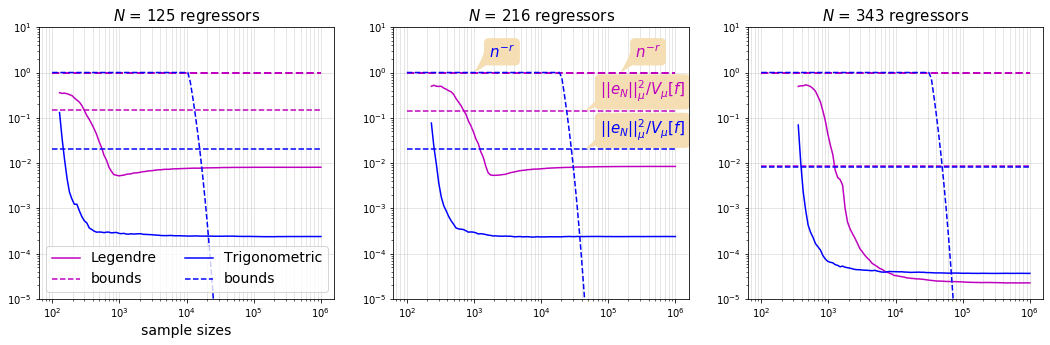

In [96]:
n_sig = len(err_S_list_Trigonometric) #len(sigma_list)

print('\n===================== %s ===========================\n'%method)

marker= "" # None #'o'
linestyle=None#'--'

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500

fontsize = 15




plt.figure(figsize=(18, 5))

for l in range(n_sig):
    
    
    # ==============================================

    K_N = N_list[l]**2 #!!!
    ka = K_N * np.log(sample_sizes) / sample_sizes
    r = -1 + (3 * np.log(3/2) - 1) / (2 * ka)
    r[r < 0] = 0
    r_leg = r.copy()

    K_N = N_list[l] #!!!
    ka = K_N * np.log(sample_sizes) / sample_sizes
    r = -1 + (3 * np.log(3/2) - 1) / (2 * ka)
    r[r < 0] = 0
    r[r > 2] = np.nan
    r_trig = r.copy()

    # ==============================================
    

    ax = plt.subplot(1, n_sig, l+1)
    
    plt.title('$N$ = {} regressors'.format(N_list[l]), fontsize=fontsize)
    
    plt.loglog(sample_sizes[ind], err_S_list_Legendre[l][ind], label='Legendre',
               linestyle=linestyle, marker=marker, color='m')
    
    plt.loglog(sample_sizes[ind],  [mse_list_Legendre[l] / var_f]*sum(ind), label='bounds',
               linestyle='--', marker=None, color='m')
        
        
    plt.loglog(sample_sizes[ind], err_S_list_Trigonometric[l][ind], label='Trigonometric',
               linestyle=linestyle, marker=marker, color='b')
    
    
    plt.loglog(sample_sizes[ind],  [mse_list_Trigonometric[l] / var_f]*sum(ind), 
               label='bounds',
               linestyle='--', marker=None, color='b')
    
    plt.loglog(sample_sizes[ind], sample_sizes[ind]**-r_leg[ind], linestyle='--', color='m', linewidth=2)
    plt.loglog(sample_sizes[ind], sample_sizes[ind]**-r_trig[ind], linestyle='--', color='b')

    
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
        
    
    plt.gca().set_ylim(top=10)
    plt.gca().set_ylim(bottom=10**-5)
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
    if l == 0:
        plt.legend(loc='best', fontsize=fontsize-1, ncol=2) #  'best', 'upper right'
        
        
    if l == 1:
        add_annotation(text=r'$n^{-r}$', textcolor='m', xy=(1.5 * 10**5, 1), xytext=(15, 15))
        add_annotation(text=r'$n^{-r}$', textcolor='b', xy=(10**3, 1), xytext=(15, 15))

        add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]$', textcolor='m', 
                       xy=(0.45 * 10**5, mse_list_Legendre[l] / var_f), xytext=(15, 15)) # r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$'
        add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]}$', textcolor='b', 
                        xy=(0.45 * 10**5, mse_list_Trigonometric[l] / var_f), xytext=(15, 15)) # r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$'
    

          
#         add_annotation(text=r'$\frac{L^2 + \sigma^2}{V_{\mu}[f]} \cdot  \frac{N}{n}$', textcolor='g', 
#                        xy=(2000, k/2000), xytext=(15, 15))
        
#     if l == 1:
#         add_annotation(text=r'$\frac{\sigma^2}{V_{\mu}[f]} \cdot  \frac{N}{n}$', textcolor='m', 
#                        xy=(1.0 * 10**5, k2/(1.2 * 10**5)), xytext=(15, 15))
        
    
if save_all:
    fname = exp_name+'_2.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

In [59]:
N_list

[125, 216, 343]

In [102]:
mse_list_Legendre / var_f, mse_list_Trigonometric / var_f

(array([0.146437  , 0.14166736, 0.00848725]),
 array([0.02009608, 0.02010029, 0.00800033]))

In [ ]:



# =================================================


# ===============================
n_sig = len(sigma_list)

marker=None #'o'
linestyle=None#'--'

fontsize = 15 # legend

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500


plt.figure(figsize=(18, 5))

for l in range(n_sig):
    

    ax = plt.subplot(1, n_sig, l+1)
    
    plt.title('$\sigma$ = {:.3f}'.format(sigma_list[l]), fontsize=fontsize)

    plt.loglog(sample_sizes[ind], err_S_proj_list[l][ind], label='proj',linestyle=linestyle, 
               marker=marker, color='g')

    plt.loglog(sample_sizes[ind], err_S_list[l][ind], label='ls',linestyle=linestyle, 
               marker=marker, color='m')
    
    k = (L**2+sigma_list[l]**2) * N / var_f
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind],linestyle='--', color='g',
              label='proj bounds') # label='bound ($L, \sigma$)'
    
    k2 = sigma_list[l]**2 * N / var_f
    plt.loglog(sample_sizes[ind], k2/sample_sizes[ind],linestyle='--', color='m') # , label='bound ($\sigma$)'
    
    
    plt.loglog(sample_sizes[ind], [mse / var_f] * sum(ind),linestyle='--', color='g', 
               linewidth=2.5) # label = 'bound ($e_N$)'
    plt.loglog(sample_sizes[ind], [mse / var_f] * sum(ind), label='ls bounds',linestyle='--', color='m') # 'bound ($e_N$)'

    plt.loglog(sample_sizes[ind], sample_sizes[ind]**-r[ind], linestyle='--', color='m') # label='$n^{-r}$',
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
        
        
    #plt.gca().set_ylim(top=10)

    
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
    
    if l == 0:
        add_annotation(text=r'$n^{-r}$', textcolor='m', xy=(0.3 * 10**5, 1), xytext=(15, 15))
#         add_annotation(text=r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$', textcolor='k', 
#                        xy=(3 * 10**5, mse / var_f), xytext=(20, 20)) 

        add_annotation(text=r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$', textcolor='m', 
                        xy=(0.4 * 10**5, mse / var_f), xytext=(20, 20))
    
        add_annotation(text=r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$', textcolor='g', 
                       xy=(2 * 10**5, mse / var_f), xytext=(20, 20))
        
            
        add_annotation(text=r'$\frac{L^2 + \sigma^2}{V_{\mu}[f]} \cdot  \frac{N}{n}$', textcolor='g', 
                       xy=(2000, k/2000), xytext=(15, 15))
        
    if l == 1:
        add_annotation(text=r'$\frac{\sigma^2}{V_{\mu}[f]} \cdot  \frac{N}{n}$', textcolor='m', 
                       xy=(1.0 * 10**5, k2/(1.2 * 10**5)), xytext=(15, 15))
        
        


In [55]:
import dill, os
print(dill.__version__)

if os.path.isfile(db_name):
    print('Not saved: file %s already exists'%db_name)
    
else:
    if save_all:
        dill.dump_session(db_name)
        print(db_name, 'is saved')

0.3.1.1
Not saved: file experiments/test_risk_diff_basis_ls_2_Ishigami.db already exists


In [97]:
def show_model_limit_mse(model, test_X, test_Y, start_power=1):
    
    print(model)
    print(model.info())
    
    var_f = np.var(test_Y)
    print('var f', var_f)
    
    num = 6 #10
    #start_power = np.log10(model._basis_functions_number + 30)
    end_power = np.log10(len(test_Y) * 0.7)
    train_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)

    
    test_size = len(test_Y) - np.max(train_sizes)
    
    print('train sizes:', train_sizes, ' + test size:', test_size)
    
    lambdas = np.array([0, 10**-4, 10**-2])# np.array([0, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])
    
    
    errs = []
    for train_size in train_sizes:
        
        err = []
        
        tr_X = test_X[:train_size]
        tr_Y = test_Y[:train_size]
        te_X = test_X[-test_size:]
        te_Y = test_Y[-test_size:]
            
        for ls_lambda in lambdas:
    
            model.fit(tr_X, tr_Y, method='ls', ls_lambda=ls_lambda)
            err += [ model.validate(te_X, te_Y)['mse']]
            
        #model.fit(tr_X, tr_Y, method='projection')
        #err += [ model.validate(te_X, te_Y)['mse']]
        
        err = np.array(err)
        
        errs += [err]
        
    errs = np.array(errs)
    
    plt.figure(figsize=(18,5))
    plt.subplot(1,2,1)
    plt.loglog(train_sizes, np.sqrt(errs / var_f))
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='both', color='#999999', axis='y',linestyle='-', alpha=0.3)
    plt.xlabel('sample sizes', fontsize=14)
    plt.title("min $\mathscr{E}$ = %s"%np.min(np.sqrt(errs / var_f)), fontsize=14)

    plt.subplot(1,2,2)
    plt.loglog(train_sizes, errs / var_f)
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='both', color='#999999', axis='y',linestyle='-', alpha=0.3)
    plt.xlabel('sample sizes', fontsize=14)
    plt.title("min $\mathscr{E}^2$ = %s"%np.min(errs / var_f), fontsize=14)


    return errs



PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric)]), basis_truncation={'max_degree': 4})
PCE model info: 
  PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric)]), basis_truncation={'max_degree': 4})

  input dimension: 3
  basis truncation: {'max_degree': 4}
  basis functions number: 125
  main Sobol indices: None
  total Sobol indices: None
  multiIndices: [[0, 0, 0], [0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0], [1, 0, 0], [1, 1, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0], [2, 0, 0], [2, 1, 0], [2, 2, 0], [2, 3, 0], [2, 4, 0], [3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 3, 0], [3, 4, 0], [4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0], [4, 4, 0], [0, 0, 1], [0, 1

/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


[[0.32071304 0.32071263 0.32495343]
 [0.28826721 0.28825244 0.28973742]
 [0.27783063 0.27782584 0.27997081]
 [0.27636682 0.27636371 0.27860564]
 [0.27586211 0.27585939 0.27809646]
 [0.2757701  0.27576686 0.27794883]]
PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric)]), basis_truncation={'max_degree': 5})
PCE model info: 
  PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric)]), basis_truncation={'max_degree': 5})

  input dimension: 3
  basis truncation: {'max_degree': 5}
  basis functions number: 216
  main Sobol indices: None
  total Sobol indices: None
  multiIndices: [[0, 0, 0], [0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0], [0, 5, 0], [1, 0, 0

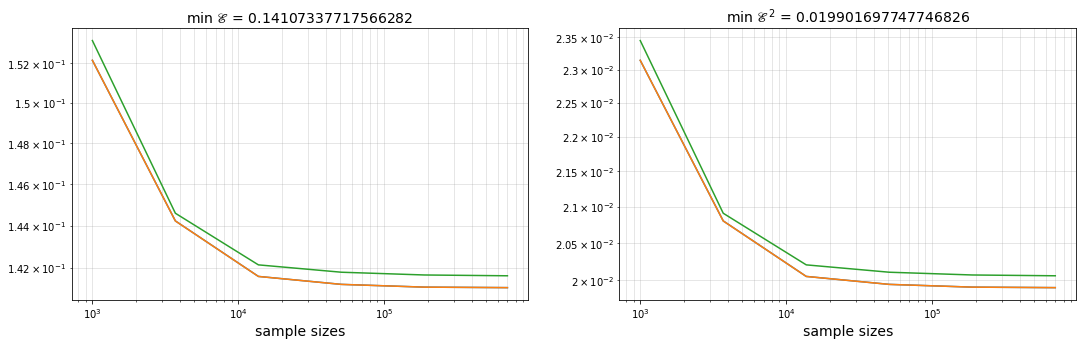

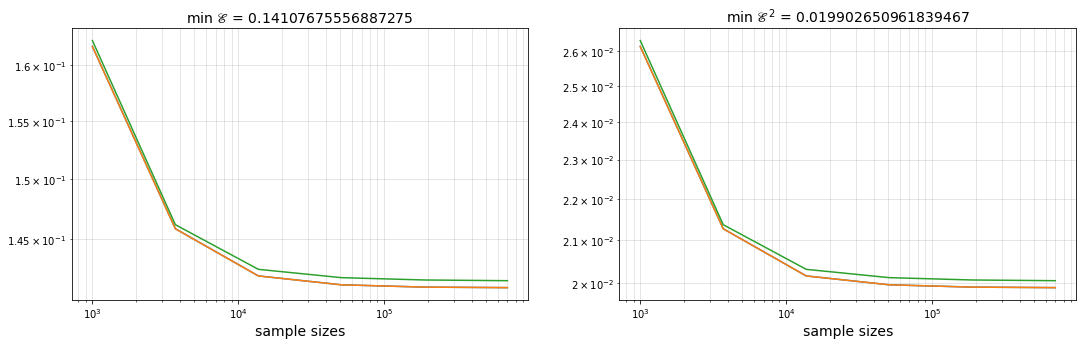

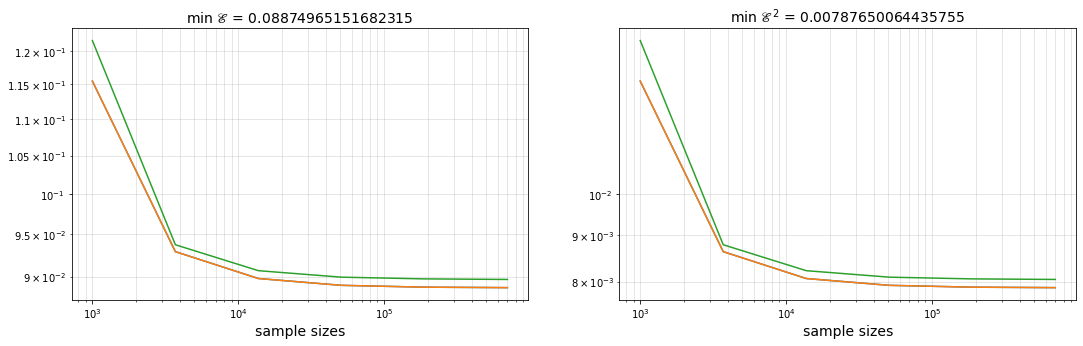

In [98]:
for max_degree in [4, 5, 6]:
    
    marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Trigonometric' )]*dim)
    model_Trigonometric = PCE(marginals, {'max_degree':max_degree})
        
    errs = show_model_limit_mse(model_Trigonometric, test_X, test_Y, start_power=3)
    print(errs)

PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre)]), basis_truncation={'max_degree': 4})
PCE model info: 
  PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre)]), basis_truncation={'max_degree': 4})

  input dimension: 3
  basis truncation: {'max_degree': 4}
  basis functions number: 125
  main Sobol indices: None
  total Sobol indices: None
  multiIndices: [[0, 0, 0], [0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0], [1, 0, 0], [1, 1, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0], [2, 0, 0], [2, 1, 0], [2, 2, 0], [2, 3, 0], [2, 4, 0], [3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 3, 0], [3, 4, 0], [4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0], [4, 4, 0], [0, 0, 1], [0, 1, 1], [0, 2, 1], [0, 3, 1], [0

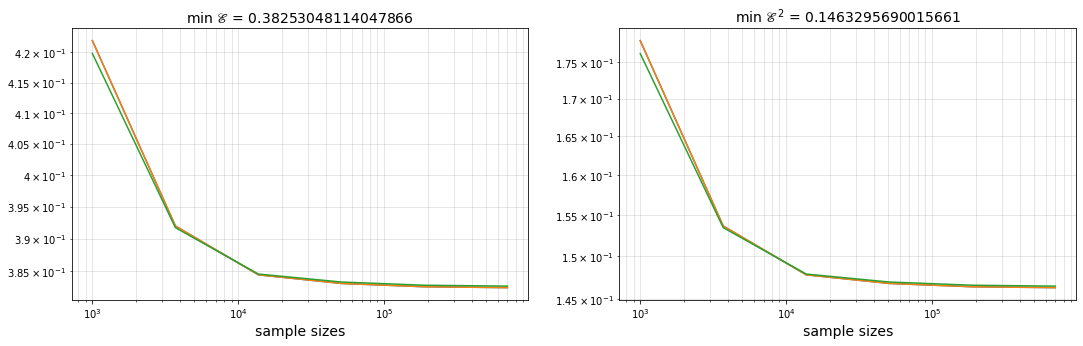

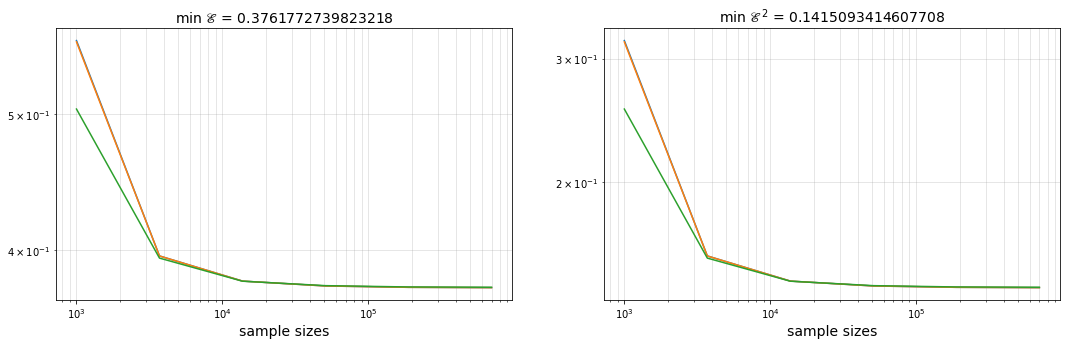

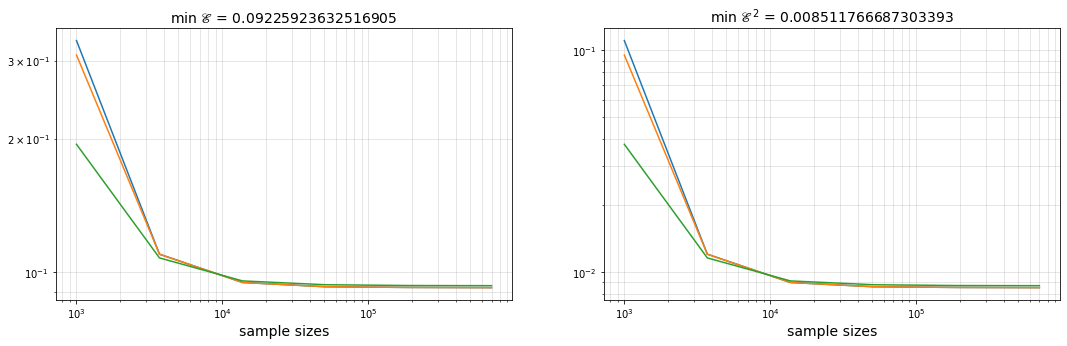

In [100]:
for max_degree in [4, 5, 6]:
    marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Legendre')]*dim)
    model_Legendre = PCE(marginals, {'max_degree':max_degree})
    errs = show_model_limit_mse(model_Legendre, test_X, test_Y, start_power=3)
    print(errs)